In [1]:
from canonymous.canonicalization import (graph_from_molfile,
                                         sort_molecule_by_attribute,
                                         partition_molecule_by_attribute,
                                         partition_molecule_recursively,
                                         assign_canonical_labels,
                                         canonicalize_molecule)
from canonymous.utils import serialize_molecule
from canonymous.visualization import print_molecule, draw_molecules
from pathlib import Path
import networkx as nx

MOLFILEPATH = "tests/testfiles"

# Canonicalization

## Molecule partitioning
The goal is to divide atoms in equivalence-classes / partitions.

First, sort the atoms by a fingerprint that consists of the atomic number and the atom's ring neighbors (elaborate).

initial
╒═════════╤═══════════════╤═════════════╤═════════════════════════════════════════════════════════════════════╕
│   index │ fingerprint   │   partition │ neighbors (index, fingerprint, partition)                           │
╞═════════╪═══════════════╪═════════════╪═════════════════════════════════════════════════════════════════════╡
│       0 │ 6543210-1     │           0 │ [(1, '6543210-1', 0), (5, '6543210-1', 0), (11, '1-1', 0)]          │
├─────────┼───────────────┼─────────────┼─────────────────────────────────────────────────────────────────────┤
│       1 │ 6543210-1     │           0 │ [(0, '6543210-1', 0), (2, '6543210-1', 0), (12, '1-1', 0)]          │
├─────────┼───────────────┼─────────────┼─────────────────────────────────────────────────────────────────────┤
│       2 │ 6543210-1     │           0 │ [(1, '6543210-1', 0), (3, '69876543210-1', 0), (13, '1-1', 0)]      │
├─────────┼───────────────┼─────────────┼───────────────────────────────────────────────────────

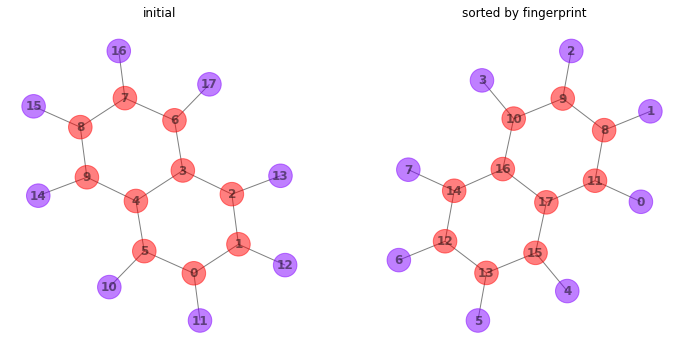

In [2]:
molecule = "naphthalene"
m = graph_from_molfile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol")
m_sorted_by_fingerprint = sort_molecule_by_attribute(m, "fingerprint")
print_molecule(m, "initial")
print_molecule(m_sorted_by_fingerprint, "sorted by fingerprint")
draw_molecules([m, m_sorted_by_fingerprint], ["initial", "sorted by fingerprint"], highlight="atomic_number")

Subsequently, the molecule is partitioned by fingerprint. Elaborate.


╒═════════╤═══════════════╤═════════════╤════════════════════════════════════════════════════════════════════════╕
│   index │ fingerprint   │   partition │ neighbors (index, fingerprint, partition)                              │
╞═════════╪═══════════════╪═════════════╪════════════════════════════════════════════════════════════════════════╡
│       0 │ 1-1           │           0 │ [(11, '6543210-1', 3)]                                                 │
├─────────┼───────────────┼─────────────┼────────────────────────────────────────────────────────────────────────┤
│       1 │ 1-1           │           0 │ [(8, '6543210-1', 2)]                                                  │
├─────────┼───────────────┼─────────────┼────────────────────────────────────────────────────────────────────────┤
│       2 │ 1-1           │           0 │ [(9, '6543210-1', 2)]                                                  │
├─────────┼───────────────┼─────────────┼──────────────────────────────────────

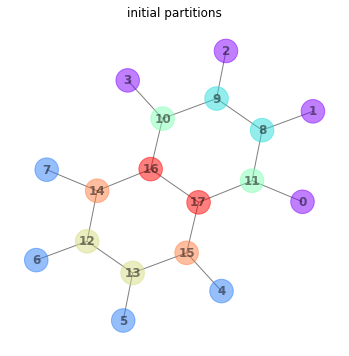

In [3]:
m_partitioned_by_fingerprint = partition_molecule_by_attribute(m_sorted_by_fingerprint, "fingerprint")
print_molecule(m_partitioned_by_fingerprint)
draw_molecules([m_partitioned_by_fingerprint], ["initial partitions"], highlight="partition")

Now, we refine the partitions recursively ("partitioning by partition"). Elaborate.

refined partitions
╒═════════╤═══════════════╤═════════════╤════════════════════════════════════════════════════════════════════════╕
│   index │ fingerprint   │   partition │ neighbors (index, fingerprint, partition)                              │
╞═════════╪═══════════════╪═════════════╪════════════════════════════════════════════════════════════════════════╡
│       0 │ 1-1           │           0 │ [(8, '6543210-1', 2)]                                                  │
├─────────┼───────────────┼─────────────┼────────────────────────────────────────────────────────────────────────┤
│       1 │ 1-1           │           0 │ [(9, '6543210-1', 2)]                                                  │
├─────────┼───────────────┼─────────────┼────────────────────────────────────────────────────────────────────────┤
│       2 │ 1-1           │           0 │ [(11, '6543210-1', 3)]                                                 │
├─────────┼───────────────┼─────────────┼────────────────────

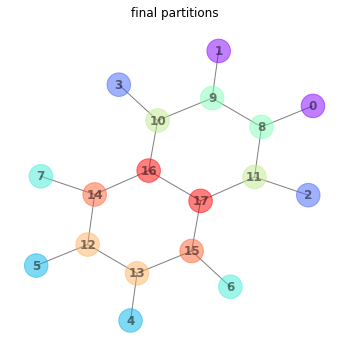

In [4]:
m_partitioned = partition_molecule_recursively(m_partitioned_by_fingerprint, show_steps=True)
draw_molecules([m_partitioned], ["final partitions"], highlight="partition")

After the recursive refinement of the partitions, many partitions contain only a few molecules. This brings us closer to the ultimate goal of the canonicalization. That is, we are closer to shattering the molecule such that each atom resides in a unique partition. How do we shatter the molecule?

## Molecule traversal

Traversing molecule deterministically by branching in a principled way based on partitions.
I.e., establish branching-priorities for situations when traversal can branch to multiple neighbors from atom A:
1. neighbor with larger partition than A
2. neighbor with smaller partition than A
3. neighbor in same partition as A

During traversal, swap indices such that the current molecule A from partition P gets assigned the smallest-available index that remains in partition P. Elaborate.

Current atom index: 0.	Re-labeling to 0.
Current atom index: 8.	Re-labeling to 8.
Current atom index: 11.	Re-labeling to 10.
Current atom index: 9.	Re-labeling to 9.
Current atom index: 17.	Re-labeling to 16.
Current atom index: 2.	Re-labeling to 2.
Current atom index: 10.	Re-labeling to 11.
Current atom index: 1.	Re-labeling to 1.
Current atom index: 15.	Re-labeling to 14.
Current atom index: 16.	Re-labeling to 17.
Current atom index: 3.	Re-labeling to 3.
Current atom index: 6.	Re-labeling to 6.
Current atom index: 13.	Re-labeling to 12.
Current atom index: 14.	Re-labeling to 15.
Current atom index: 4.	Re-labeling to 4.
Current atom index: 12.	Re-labeling to 13.
Current atom index: 7.	Re-labeling to 7.
Current atom index: 5.	Re-labeling to 5.


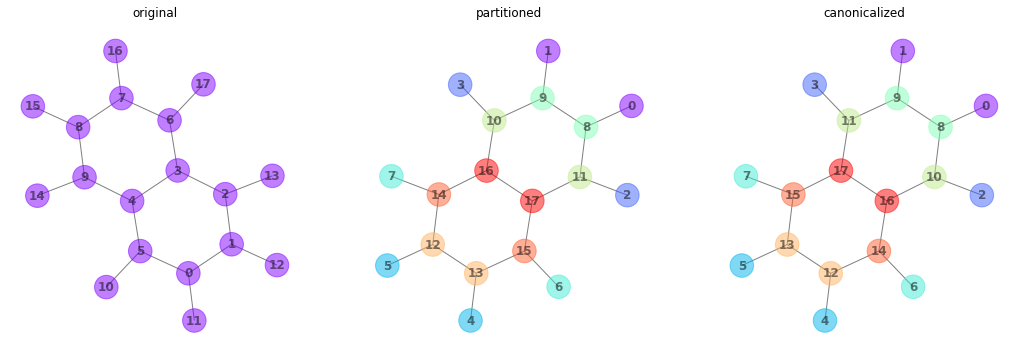

In [5]:
canonical_idcs = assign_canonical_labels(m_partitioned, 0, show_traversal_order=True)
m_canonicalized = nx.relabel_nodes(m_partitioned, canonical_idcs, copy=True)

draw_molecules([m, m_partitioned, m_canonicalized], ["original", "partitioned", "canonicalized"], highlight="partition")

# Serialization
The serialization should result in a string representation of the molecule. The string representation should allow for the automatized reconstruction of the molecule's topology (i.e., the molecular graph). Additionally, ideally the representation should be intuitive enough for a human to be able to reconstruct the molecular graph.

Our string representation consists of the sum formula, followed by a sequence of tuples. Each tuple represents the indices of two connected atoms (i.e., (index X, index Y)). For example, the string representation of ethanol is `C2H6O/0-6/1-6/2-6/3-7/4-7/5-8/6-7/7-8`. In order to be able to reconstruct the molecule based on this representation, we organize the tuples such that increasing indices pertain to atoms with increasing atomic number. This means that we can infer an atom's atomic number from the sum formula. For example, the sum formula of ethanol indicates that the molecule consists of six Hs, two Cs and one O. Since increasing indices pertain to atoms with increasing atomic numbers, we can infer that the indices 0 to 6 pertain to Hs, indices 7 and 8 pertain to Cs, and finally, index 8 pertains to an O.

In [6]:
testfiles = list(Path("tests/testfiles").glob("*/*.mol"))
for f in testfiles:
    m = graph_from_molfile(f)
    print(f"{f.stem}:\n{serialize_molecule(canonicalize_molecule(m, 0))}\n")

2 4 Dimethylbutan:
C6H14/0-14/1-14/2-14/3-15/4-15/5-15/6-16/7-16/8-16/9-17/10-17/11-17/12-18/13-19/14-18/15-18/16-19/17-19/18-19

2 Chlortoluol:
C7H7Cl/0-8/1-8/2-8/3-9/4-10/5-11/6-12/7-13/8-14/9-10/9-11/10-12/11-13/12-14/13-14

2-8-dimethyldecane:
C12H26/0-26/1-26/2-26/3-27/4-27/5-27/6-28/7-28/8-28/9-29/10-29/11-29/12-30/13-30/14-31/15-31/16-32/17-32/18-33/19-33/20-34/21-34/22-35/23-35/24-36/25-37/26-33/27-36/28-36/29-37/30-31/30-32/31-34/32-35/33-37/34-36/35-37

2-aminopyridine:
C5H6N2/0-6/1-7/2-8/3-9/4-11/5-11/6-7/6-8/7-9/8-10/9-12/10-11/10-12

3 Chlortoluol:
C7H7Cl/0-8/1-8/2-8/3-9/4-10/5-11/6-12/7-13/8-14/9-10/9-11/10-13/11-14/12-13/12-14

3 Methylpentan:
C6H14/0-14/1-14/2-14/3-15/4-15/5-15/6-16/7-16/8-16/9-17/10-17/11-18/12-18/13-19/14-17/15-18/16-19/17-19/18-19

4 Chlortoluol:
C7H7Cl/0-8/1-8/2-8/3-9/4-10/5-11/6-12/7-13/8-14/9-11/9-13/10-12/10-13/11-14/12-14

acetylacetonate:
C5H8O2/0-8/1-8/2-8/3-9/4-9/5-9/6-10/7-10/8-11/9-12/10-11/10-12/11-13/12-14

ammonia:
H3N/0-3/1-3/2-3

anthr